In [3]:
import sys
sys.path.insert(0, '../')

# predict_model pipeline

This notebook explains how to make predictions with the trained model. The predictions will be plotted against the targets, and root mean squared error (RMSE) will be reported both for the predictions and the baseline, which is the mean of the targets, along with the correlation between predictions and targets.

It is important that the correct fold is selected as the statistics used during training are also necessary to be used during prediction.

#### ***Quick Start***

If you are only interested in predicting with the model using default parameters (i.e. features from Hydra only) you can do so by calling

```
python src/predict_model.py
```

This will predict on the entire test set, saving a plot of the predictions in ```reports/figures/model_results```.

## Step 1 - Creating the dataset and dataloader

**File:** ```src/data/features_dataloader.py```

We start off with creating a torch dataset over the test Features and plot a histogram of the targets.

Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             test 
                     Data length:           1446 
                     Features selected:                      
                         - Names:           ['HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     


100%|██████████| 1446/1446 [00:00<00:00, 5572.10it/s]


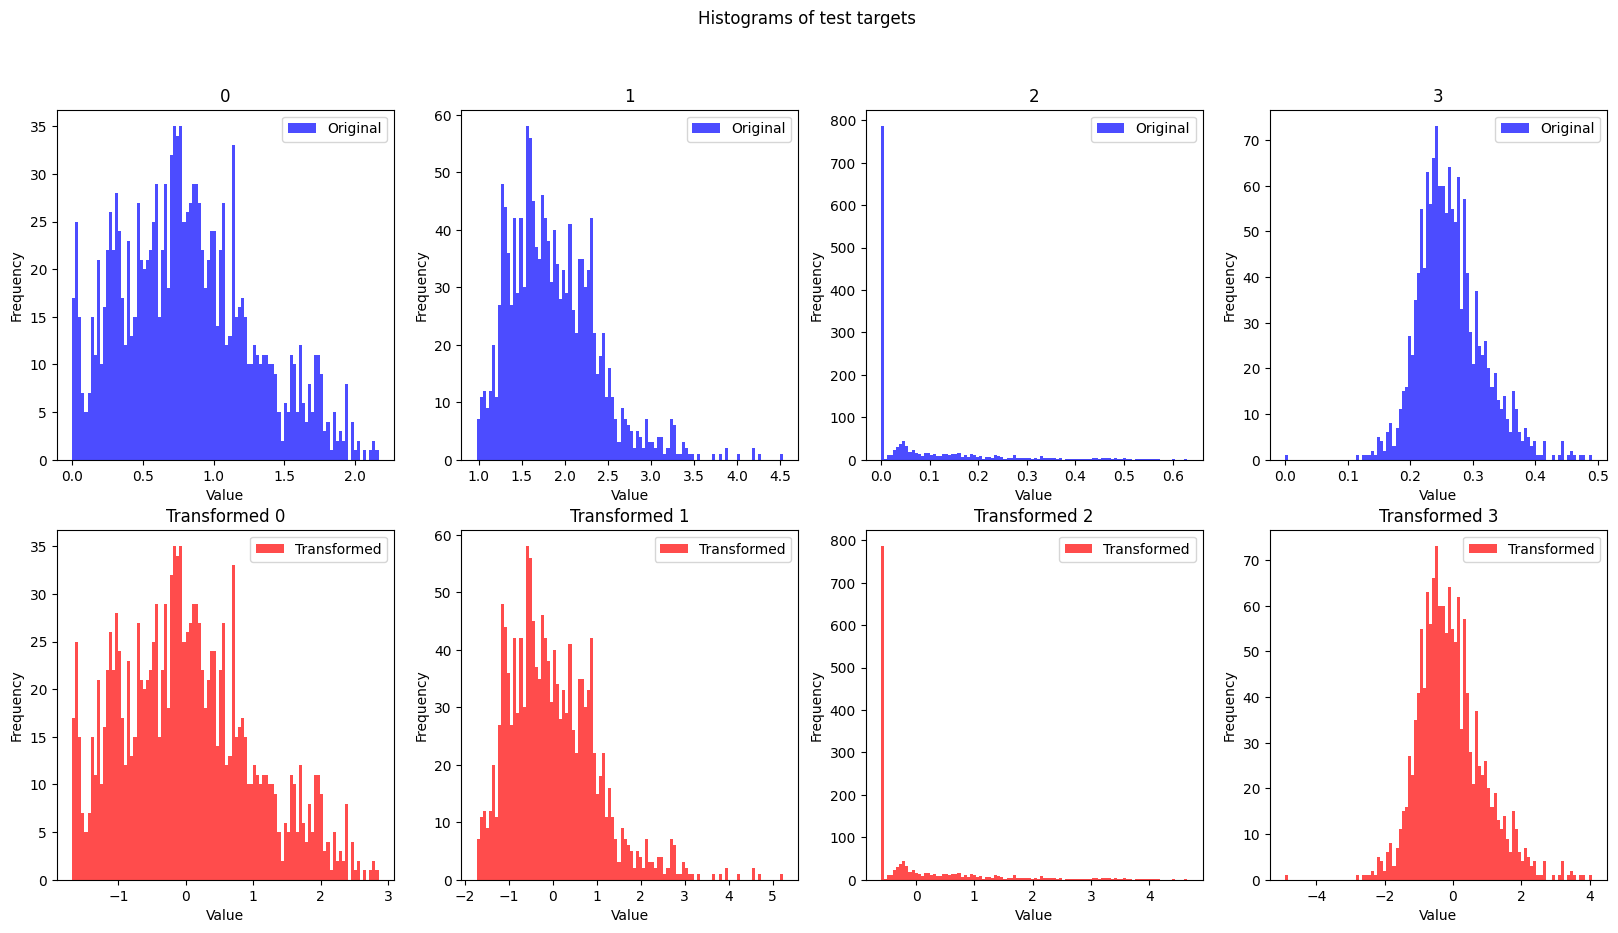

In [19]:
from src.data.feature_dataloader import Features

testset = Features(data_path = '../data/processed/features.hdf5',
                   data_type = 'test',
                   feature_extractors = ['HydraMV_8_64'],
                   fold = 3,
                   name_identifier = '')

testset.plot_data()

## Step 2 - Predicting using the trained model

**File:** ```src/predict_model.py```

We are now ready to use the model we trained (as demonstrated in ```train_model.ipynb```), and make predictions on our road segments. 

***Imports***

In [20]:
import os
import torch
import torch.nn as nn
import numpy as np
from argparse import ArgumentParser
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

from src.util.utils import set_all_seeds
from src.data.feature_dataloader import Features
from src.models.hydramr import HydraMRRegressor, HydraMRRegressor_old

# Set all seeds for reproducibility
set_all_seeds(42)

***The following variables are parameters that can set via arguments when calling ```predict_model.py```***

In [27]:
model_path = '../models/HydraMRRegressor.pt'            # Path to the model
data = '../data/processed/features.hdf5'             # Path to the data
data_type = 'test'                              # Type of data to load
feature_extractors = ['HydraMV_8_64']           # Feature extractors to use (which of the features in the data to load for prediction)
name_identifier = ''                            # Additional identifier for the data (feature extractor name)
batch_size = 32                                 # Batch size
plot_during = False                             # Plot the predictions during evaluation
hidden_dim = 64                                 # Hidden dimension of the model (must be same as trained model)
fold = 3                                        # Fold of the data to use (must be same as trained model for correct normalization)
model_depth = 0                                 # Depth of the model (must be same as trained model)
batch_norm = True                               # Use batch normalization

***Calculate errors function***

This function takes the predictions and targets, and calculates the root mean squared error (RMSE) between them, as well as the RMSE between a baseline guess (mean of the targets) and the targets.

In [22]:
def calculate_errors(predictions, targets):
    """Calculate the errors between the predictions and the targets.
    
    Parameters:
    ----------
        predictions (np.array): The predictions made by the model.
        targets (np.array): The true values of the targets.
    
    Returns:
    -------
        RMSE (np.array): The Root Mean Squared Error between the predictions and the targets for each KPI.
        baseline_RMSE (np.array): The Root Mean Squared Error between the targets and the mean of the targets for each KPI.
    """
    
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().numpy()
    
    # Calculate RMSE between targets and predictions for each KPI
    RMSE = np.sqrt(np.mean(np.abs(targets - predictions)**2, axis=0))
    
    # Calculate baseline RMSE between targets and predictions for each KPI
    baseline_RMSE = np.sqrt(np.mean(np.abs(targets - np.mean(targets, axis=0))**2, axis=0))
    
    return RMSE, baseline_RMSE

***Plot predictions function***

This function takes the predictions and targets and creates a scatter plot of them, to visualize the performance of the model.

In [31]:
def plot_predictions(predictions: torch.Tensor, targets: torch.Tensor, show: bool = False):
    """Plot the predictions against teh targets in a scatter plot. Also reports the RMSE and correlation between the predictions and the targets.

    Args:
        predictions (torch.Tensor): Targets predicted by the model.
        targets (torch.Tensor): Real targets.
        show (bool, optional): Whether or not to show the plot in addition to saving it. Defaults to False.
    """
    predictions = predictions.detach().numpy()
    targets = targets.detach().numpy()
    
    red_colors = ['lightcoral', 'firebrick', 'darkred', 'red']
    blue_colors = ['lightblue', 'royalblue', 'darkblue', 'blue']
    KPI = ['Damage Index (DI)', 'Rutting Index (RUT)', 'Patching Index (PI)', 'International Rougness Index (IRI)']
    
    # Setup plot
    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    axes = axes.flat
    
    # Get errors
    rmse, baseline_rmse = calculate_errors(predictions, targets)
    
    correlations = []
    # Plot each KPIs
    for i in range(len(axes)):
        correlation = np.corrcoef(targets[:, i], predictions[:, i])[0, 1]
        correlations.append(correlation)
        
        # Set limits
        xlim_min = min(min(targets[:, i]), min(predictions[:, i])) - 0.1
        ylim_min = min(min(targets[:, i]), min(predictions[:, i])) - 0.1
        xlim_max = max(max(targets[:, i]), max(predictions[:, i])) + 0.1
        ylim_max = max(max(targets[:, i]), max(predictions[:, i])) + 0.1
        axes[i].set_xlim(xlim_min, xlim_max)
        axes[i].set_ylim(ylim_min, ylim_max)
        
        # Plot diagonal
        axes[i].plot([xlim_min, xlim_max], [ylim_min, ylim_max], color='black', linestyle='dashed', linewidth=1, alpha=.75, zorder=1)
        
        # Plot mean target
        axes[i].axhline(np.mean(targets[:, i]), color='goldenrod', linestyle='dashed', linewidth=1, alpha=.75, label='Mean Target (baseline)', zorder=1)
        
        # Plot scatter
        axes[i].scatter(targets[:, i], predictions[:, i], color='indianred', alpha=.75, label='Predicted vs Target', zorder=0)
        axes[i].set_xlabel('Target', fontsize=12)
        axes[i].set_ylabel('Prediction', fontsize=12)
        
        # Set title
        axes[i].title = axes[i].set_title(f'{KPI[i]}\nRMSE: {rmse[i]:.2f}, baseline RMSE: {baseline_rmse[i]:.2f}, correlation: {correlation:.2f}')
        axes[i].legend()
    
    data_type_name = data_type.capitalize()
    path_to_model = Path(model_path).stem
    if path_to_model.startswith('best_'):
        path_to_model = path_to_model[5:]
    
    # loss: {np.mean(test_losses):.2f},
    plt.suptitle(f'{data_type_name} Predictions vs Targets\nRMSE: {np.mean(rmse):.2f}, baseline RMSE: {np.mean(baseline_rmse):.2f}. correlation: {np.mean(correlations):.2f}', fontsize=24)
    plt.tight_layout()
    plt.savefig(f'../reports/figures/model_results/{path_to_model}/{data_type}_predictions.pdf')
    if show:
        plt.show()
    plt.close()

***Predict function***

In [32]:
def predict(model: torch.nn.Module, testloader: torch.utils.data.DataLoader):
    """Run prediction for a given model and dataloader.
    
    Parameters:
    ----------
        model: model to use for prediction
        testloader: dataloader to use for prediction
    
    Returns:
    -------
        all_predictions, all_targets, test_losses: predictions, targets and losses for the test set

    """
    model.eval()
    
    all_predictions = torch.tensor([])
    all_targets = torch.tensor([])
    test_losses = np.array([])
    
    test_iterator = tqdm(testloader, unit="batch", position=0, leave=False)

    kpi_means = torch.tensor(testset.kpi_means)
    kpi_stds = torch.tensor(testset.kpi_stds)
    
    for data, targets in test_iterator:
        output = model(data)
        
        # Convert back from standardized to original scale
        output = ((output * kpi_stds) + kpi_means)
        targets = ((targets * kpi_stds) + kpi_means)
        
        loss_fn = nn.MSELoss()
        all_predictions = torch.cat((all_predictions, output), dim=0)
        all_targets = torch.cat((all_targets, targets), dim=0)
        
        test_loss = torch.sqrt(loss_fn(output, targets)).item()
        test_losses = np.append(test_losses, test_loss)
        
        test_iterator.set_description(f'Overall RMSE (loss): {test_losses.mean():.2f} Batch RMSE (loss): {test_loss:.2f}')
        
        if plot_during:
            plot_predictions(all_predictions.detach().numpy(), all_targets.detach().numpy(), test_losses)
        
    return all_predictions, all_targets, test_losses

***Predicting using the above functions***

We are now ready to predict using the functions above. Because we have set everything up in the functions, only a very small script is needed.

Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             test 
                     Data length:           1446 
                     Features selected:                      
                         - Names:           ['Hydra_8_64'] 
                         - KPI Window Size: 1 
                     


  0%|          | 0/46 [00:00<?, ?batch/s]

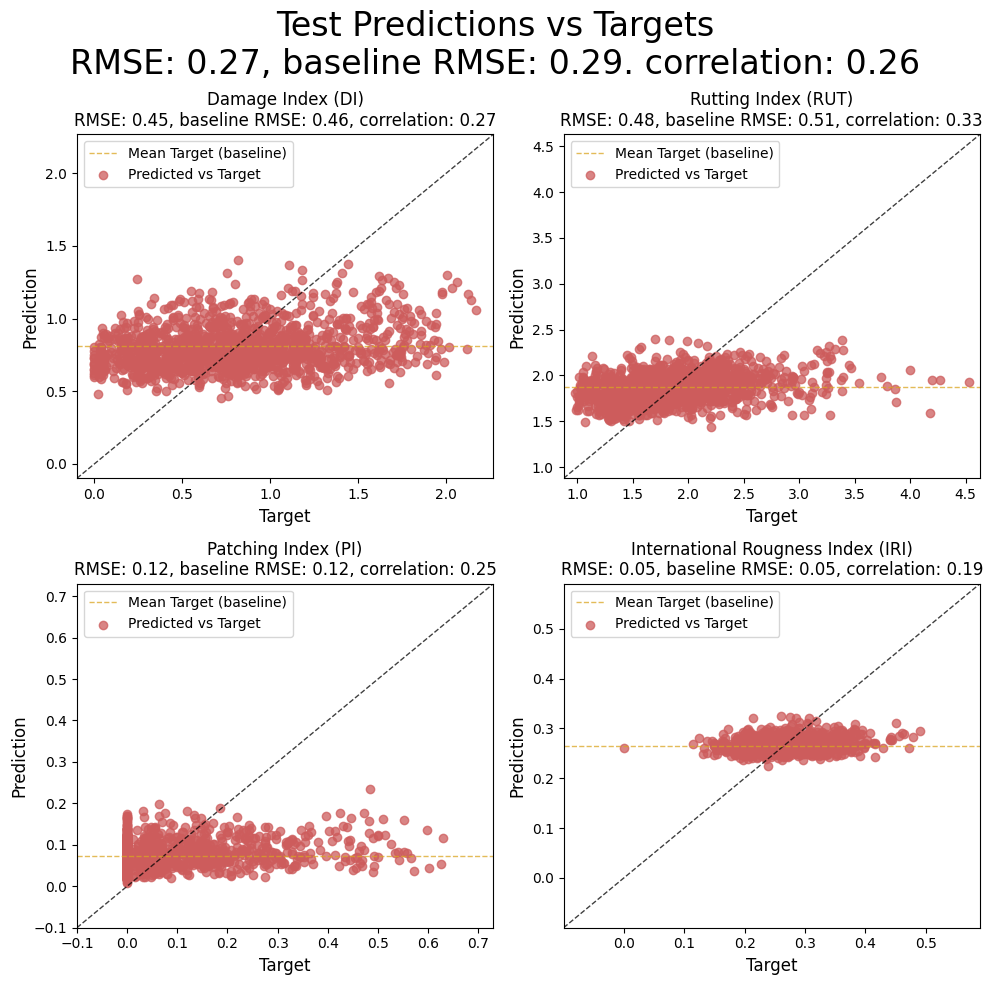

In [33]:
# Load the data
testset = Features(data_path = data,
                   data_type = data_type,
                   feature_extractors = feature_extractors,
                   fold = fold,
                   name_identifier = name_identifier)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Setup and load the model
input_shape, target_shape = testset.get_data_shape()
model = HydraMRRegressor(in_features = input_shape[0], 
                         out_features = target_shape[0], 
                         hidden_dim = hidden_dim, 
                         model_depth = model_depth, 
                         batch_norm = batch_norm)
model.load_state_dict(torch.load(model_path))

# Predict using the model
predictions, targets, test_losses = predict(model, testloader)

# Plot the predictions
plot_predictions(predictions, targets, show=True)
